In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install --upgrade statsmodels
!pip install pmdarima
from datetime import datetime
import pandas_datareader as web
import json
import plotly.express as px
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing
import statsmodels.api as sm
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

**Reading data from Yahoo Finance**


---



In [ ]:
today = datetime.now()
stocks =  ["AAPL", "GOOGL", "FB", "AMZN", "WMT", "BAC", "WFC", "AXP", "GE", "GM"]

stock_objects = {"AAPL":[], "GOOGL":[], "FB":[], "AMZN":[], "WMT":[], "BAC":[], "WFC":[], "AXP":[], "GE":[], "GM":[]}
data_source = 'yahoo'

for i in range(len(stocks)):
  stock_df = web.DataReader(stocks[i], data_source, start = "2015-08-26 00:00:00", end = "2022-02-28 00:00:00")['Close']
  stock_df = pd.DataFrame(stock_df)
  stock_objects[stocks[i]].append(stock_df.to_json(orient='columns'))

In [ ]:
def generate_stock_df(dictionary, ticker):
  df = json.dumps(dictionary[ticker]).replace("[","").replace("]","")
  df = pd.read_json(json.loads(df))
  return df

**Decomposing Time series**


---



In [ ]:
stock_objects_updated = {"AAPL":[], "GOOGL":[], "FB":[], "AMZN":[], "WMT":[], "BAC":[], "WFC":[], "AXP":[], "GE":[], "GM":[]}

def append_trend_to_dict(dictionary):
  for i in range(len(stocks)):
    df = web.DataReader(stocks[i], data_source, start = "2015-08-26 00:00:00", end = "2022-02-28 00:00:00")['Close']
    df = pd.DataFrame(df)
    ts_decompose_add = seasonal_decompose(df['Close'], model='additive', period=60)
    df["Trend"] = ts_decompose_add.trend
    dictionary[stocks[i]].append(df.to_json(orient='columns'))
  return dictionary


In [ ]:
append_trend_to_dict(stock_objects_updated)

**Dynamic Time Warping with the Market reference (S&P500)**


---



In [ ]:
SPY = web.DataReader("SPY", data_source, start = "2015-08-26 00:00:00", end = "2022-02-28 00:00:00")['Close']
SPY = pd.DataFrame(SPY)
ts_decompose_SPY = seasonal_decompose(SPY['Close'], model='additive', period=60)
SPY["Trend"] = ts_decompose_SPY.trend
SPY = SPY.dropna()

In [ ]:
for i in range(len(stocks)):
  df_trend = generate_stock_df(stock_objects_updated, stocks[i])['Trend']
  df_trend = df_trend.dropna()
  distance, path = fastdtw(SPY['Trend'], df_trend, dist=euclidean)
  print("Stock: {}".format(stocks[i]))
  print("Distance: {}".format(distance))
  print("__________________________________________________")


Stock: AAPL
Distance: 357346.5813930024
__________________________________________________
Stock: GOOGL
Distance: 1616840.9088794754
__________________________________________________
Stock: FB
Distance: 68376.53186163105
__________________________________________________
Stock: AMZN
Distance: 2406345.9409964248
__________________________________________________
Stock: WMT
Distance: 300068.185589568
__________________________________________________
Stock: BAC
Distance: 417956.9460017045
__________________________________________________
Stock: WFC
Distance: 386499.20493694855
__________________________________________________
Stock: AXP
Distance: 297418.4156531025
__________________________________________________
Stock: GE
Distance: 260505.55094502028
__________________________________________________
Stock: GM
Distance: 400598.8903788384
__________________________________________________


In [ ]:
def save_result(i):
  df_trend = generate_stock_df(stock_objects_updated, stocks[i])['Trend']
  df_trend = df_trend.dropna()
  distance, path = fastdtw(SPY['Trend'], df_trend, dist=euclidean)
  return stocks[i], distance

In [ ]:
save_result(0)

('AAPL', 357346.5813930024)

**Granger Causality**

The stock closest to the trend of the S&P500 is the GM. For the other stocks, the null hypothesis was not rejected.

In [ ]:
for i in range(len(stocks)):
  stock_trend = generate_stock_df(stock_objects_updated, stocks[i])['Trend']
  stock_trend = pd.DataFrame(stock_trend)
  stock_trend = stock_trend.dropna()
  SPY_trend = SPY.drop("Close", axis=1)
  df_join=pd.merge(stock_trend, SPY_trend, left_index=True, right_index=True)

  grangercausalitytests(df_join[['Trend_x', "Trend_y"]], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5585  , p=0.0002  , df_denom=1569, df_num=3
ssr based chi2 test:   chi2=19.7634 , p=0.0002  , df=3
likelihood ratio test: chi2=19.6405 , p=0.0002  , df=3
parameter F test:         F=6.5585  , p=0.0002  , df_denom=1569, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1116  , p=0.3432  , df_denom=1569, df_num=3
ssr based chi2 test:   chi2=3.3498  , p=0.3408  , df=3
likelihood ratio test: chi2=3.3462  , p=0.3413  , df=3
parameter F test:         F=1.1116  , p=0.3432  , df_denom=1569, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3005  , p=0.8251  , df_denom=1569, df_num=3
ssr based chi2 test:   chi2=0.9055  , p=0.8241  , df=3
likelihood ratio test: chi2=0.9052  , p=0.8242  , df=3
parameter F test:         F=0.3005  , p=0.8251  , df_denom=1569, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0426  , p=0.

**Creating Function that calculates the DTW (euclidean distance) from one stock to another**


---



In [ ]:
def dtw(start_date, end_date, ticker_1, ticker_2):

  var1 = "data_{}".format(ticker_1)
  var2 = "data_{}".format(ticker_2)

  var3 = "ts_decompose_{}".format(ticker_1)
  var4 = "ts_decompose_{}".format(ticker_2)

  globals()[var1] = web.DataReader(ticker_1, data_source, start = start_date, end = end_date)['Close']
  globals()[var2] = web.DataReader(ticker_2, data_source, start = start_date, end = end_date)['Close']

  globals()[var1] = pd.DataFrame(globals()[var1])
  globals()[var2] = pd.DataFrame(globals()[var2])

  globals()[var3] = seasonal_decompose(globals()[var1]['Close'], model='additive', period=60)
  globals()[var4] = seasonal_decompose(globals()[var2]['Close'], model='additive', period=60)

  globals()[var1]["Trend"] = globals()[var3].trend
  globals()[var2]["Trend"] = globals()[var4].trend

  globals()[var1] = globals()[var1].dropna()
  globals()[var2] = globals()[var2].dropna()

  globals()[var1] = globals()[var1].drop("Close", axis=1)
  globals()[var2] = globals()[var2].drop("Close", axis=1)


  data_join=pd.merge(globals()[var1], globals()[var2], left_index=True, right_index=True)

  distance, path = fastdtw(data_join['Trend_x'], data_join['Trend_y'], dist=euclidean)

  return "The distance for {} is {}".format(ticker_1, distance) #add path if desired

In [ ]:
#Analysis starting at Jan 1st, 2021
print(dtw("2021-01-01",datetime.now(),"FB","SPY"))
print(dtw("2021-01-01",datetime.now(),"GE","SPY"))

The distance for FB is 30592.042787679035
The distance for GE is 87779.46605478917


**Charts, Fuller test, time series decomposing**


---



In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np

In [ ]:
fb_df = generate_stock_df(stock_objects_updated, 'FB')
ge_df = generate_stock_df(stock_objects_updated, 'GE')
#ge_df = ge_df[(ge_df.index > "2019-02-01")] #analysis for the last 3 years
fb_df = fb_df.dropna()
ge_df = ge_df.dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(24, 8))
    orig = plt.plot(timeseries, color='#9E9E9E',label='Original')
    mean = plt.plot(rolmean, color='#3E7CE9', label='Rolling Mean')
    std = plt.plot(rolstd, color='#E1A85D', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC') #maxlag = 300
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

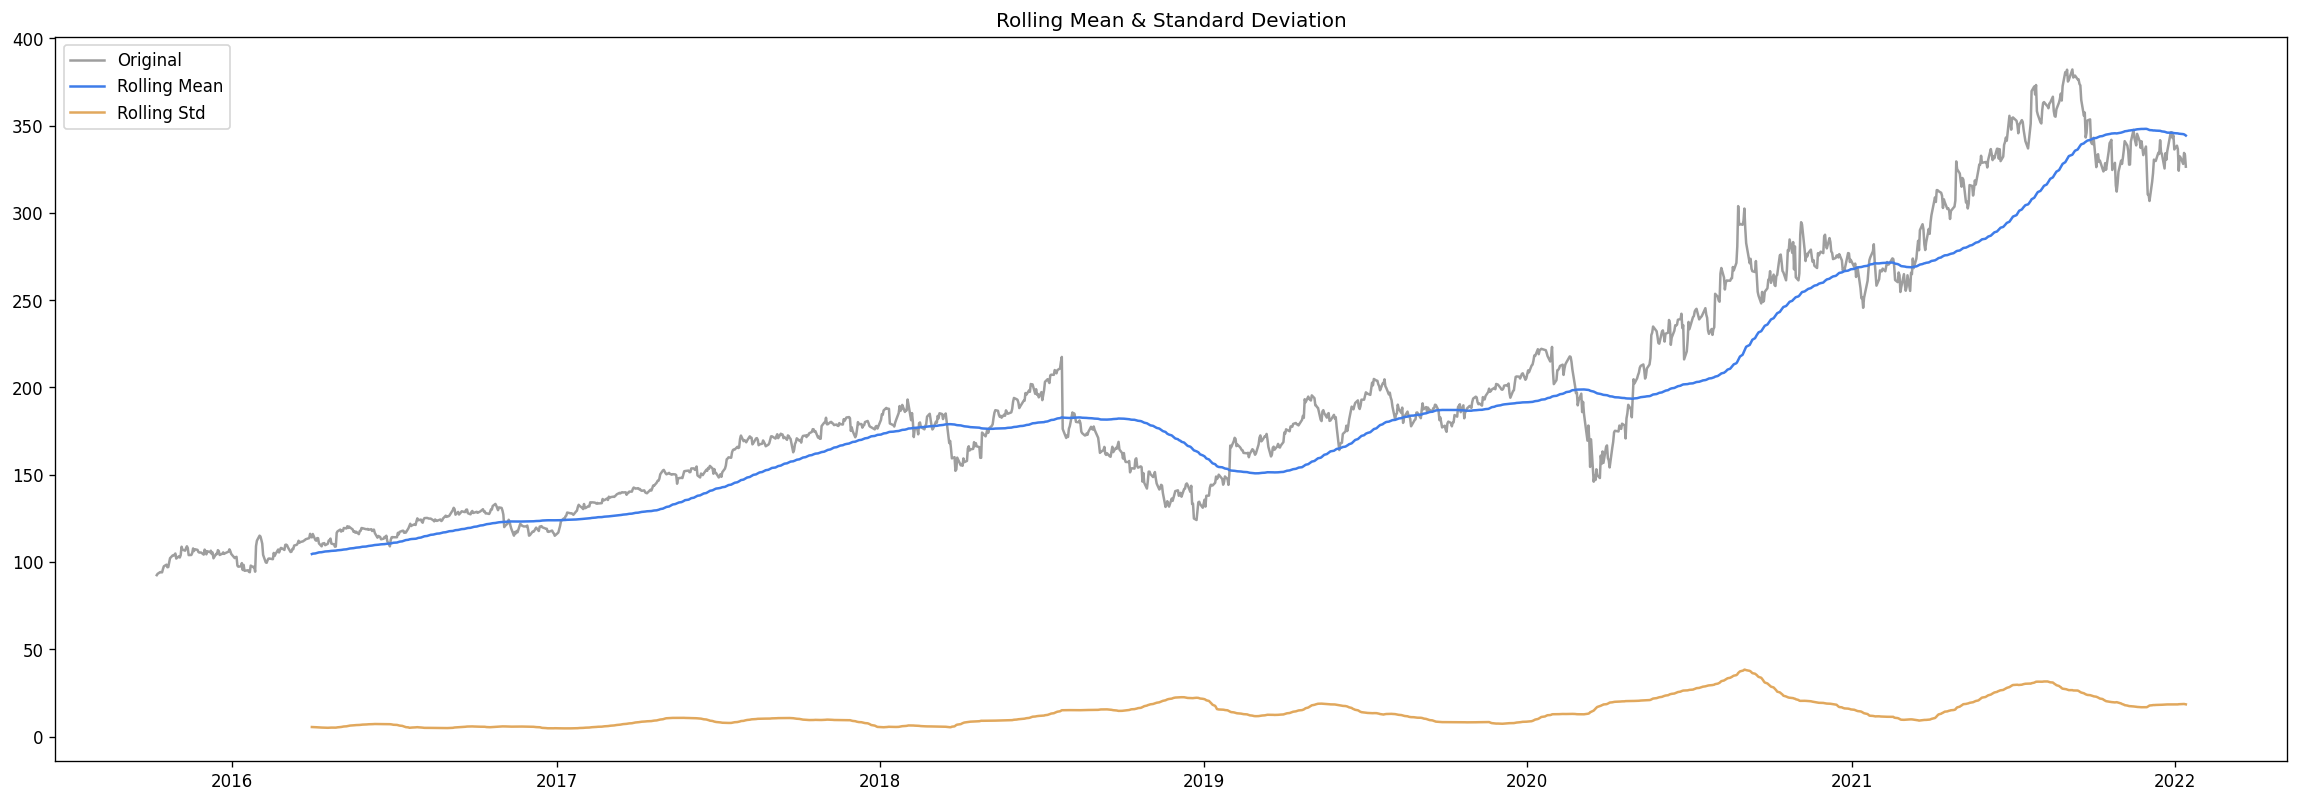

Results of Dickey-Fuller Test:
p-value = 0.8764. The series is likely non-stationary.
Test Statistic                   -0.575447
p-value                           0.876434
#Lags Used                       18.000000
Number of Observations Used    1560.000000
Critical Value (1%)              -3.434549
Critical Value (5%)              -2.863395
Critical Value (10%)             -2.567757
dtype: float64


In [ ]:
#Given the P-value clearly the series is non-stationary
test_stationarity(fb_df['Close'], 120)

In [ ]:
ts_decompose_add_fb = seasonal_decompose(fb_df['Close'], model='additive', period=120)

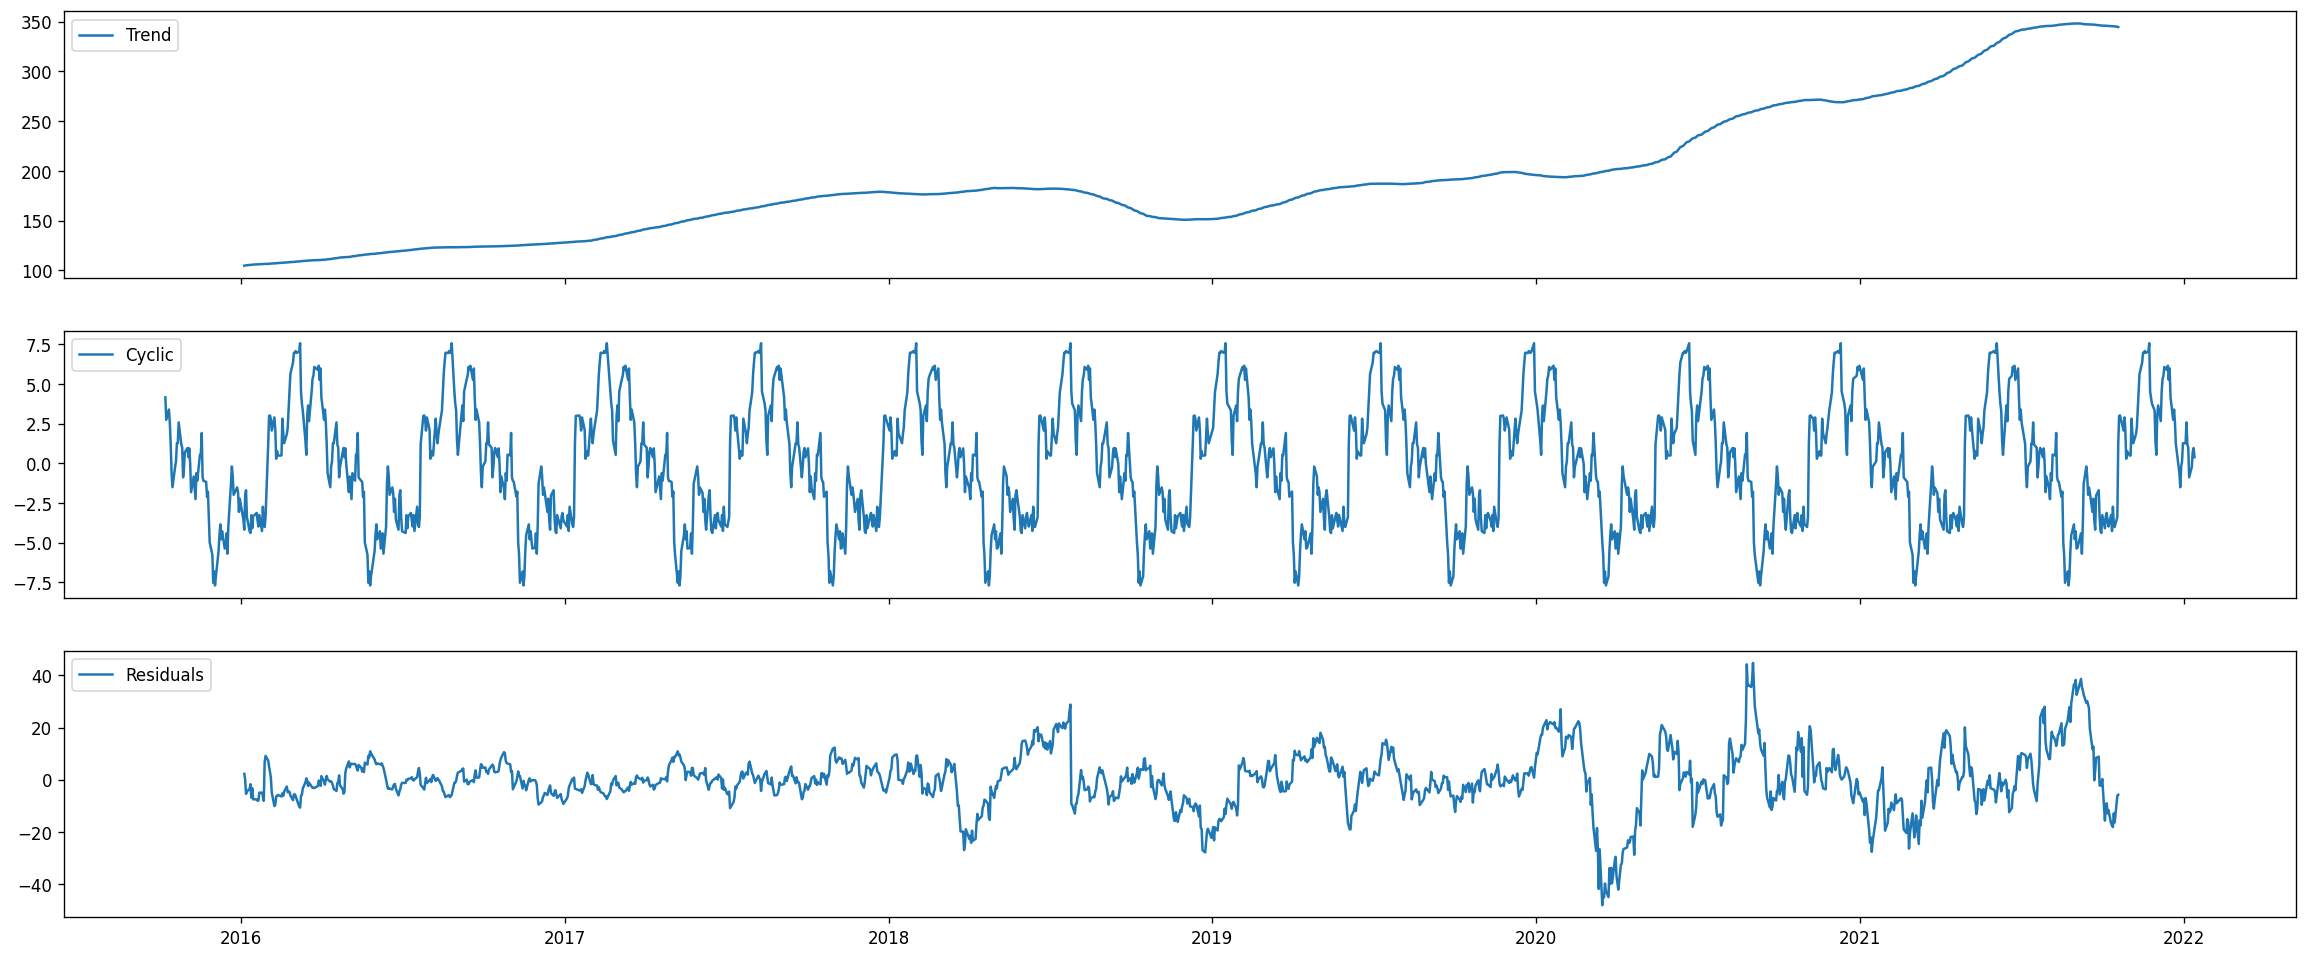

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(24)

axes[0].plot(ts_decompose_add_fb.trend, label='Trend')
axes[0].legend(loc='upper left');

axes[1].plot(ts_decompose_add_fb.seasonal, label='Cyclic')
axes[1].legend(loc='upper left');

axes[2].plot(ts_decompose_add_fb.resid, label='Residuals')
axes[2].legend(loc='upper left');

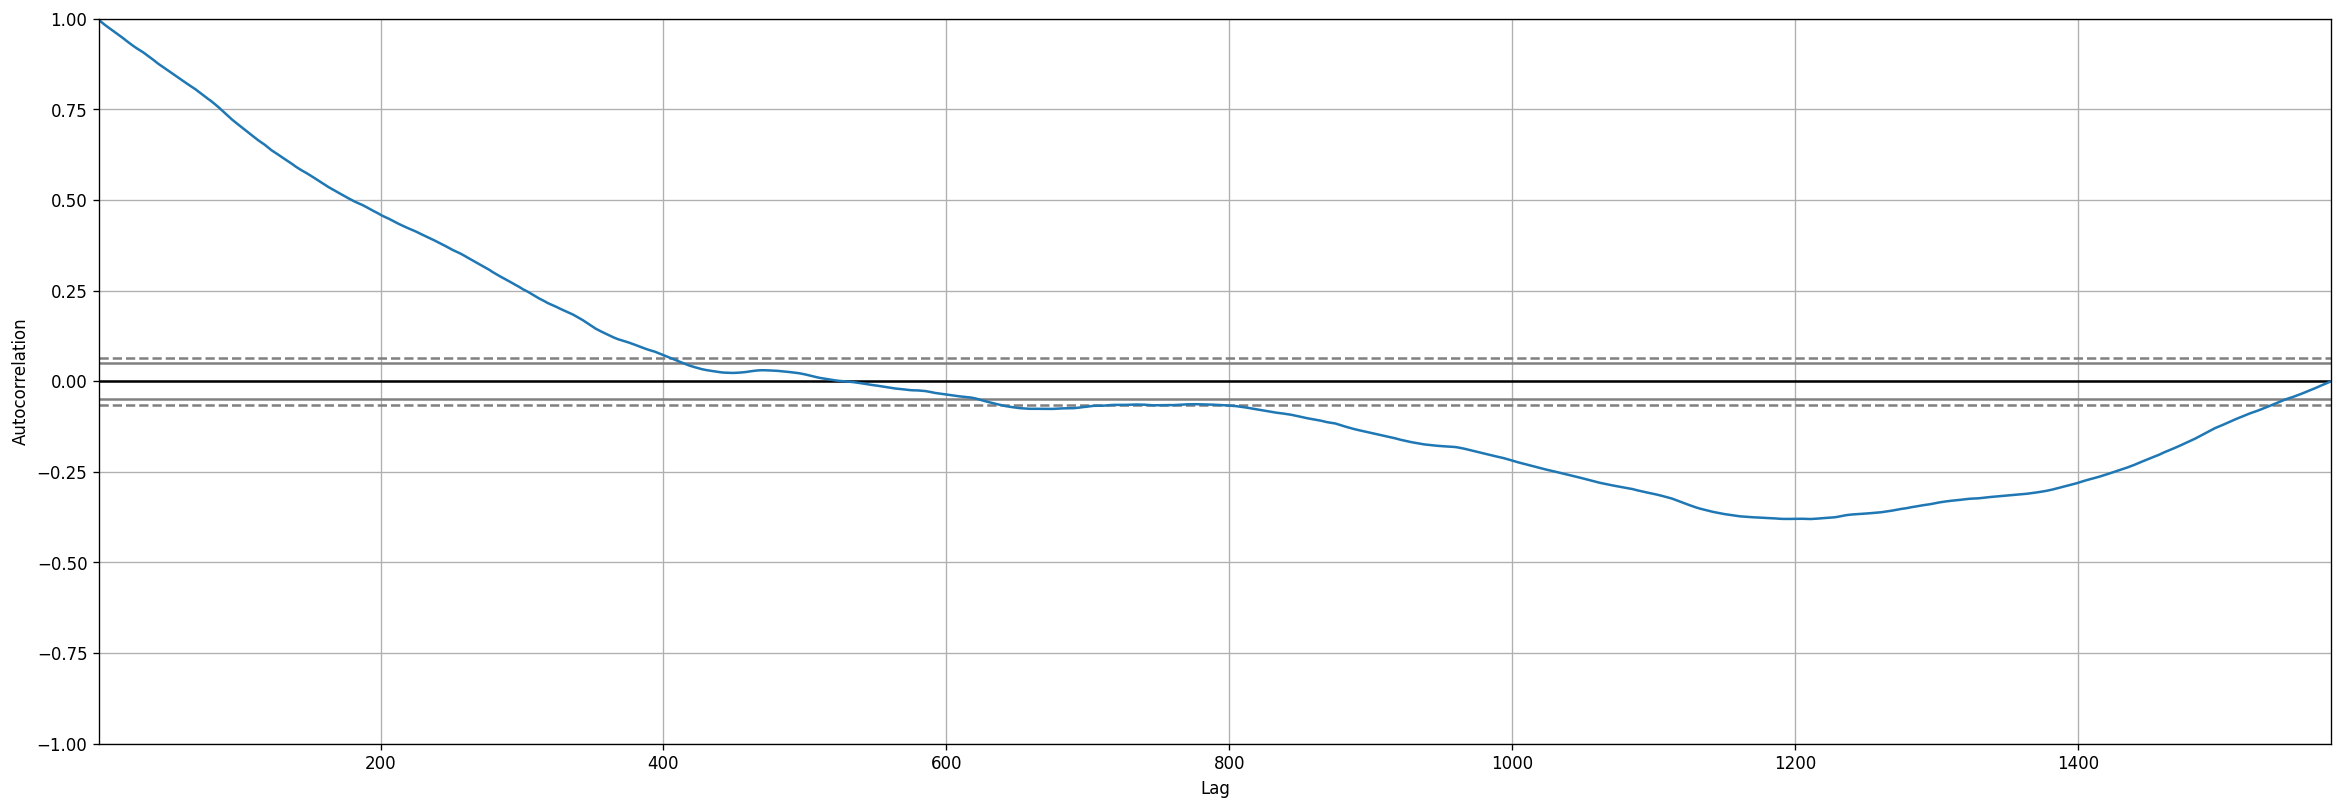

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))
autocorrelation_plot(fb_df['Close'])

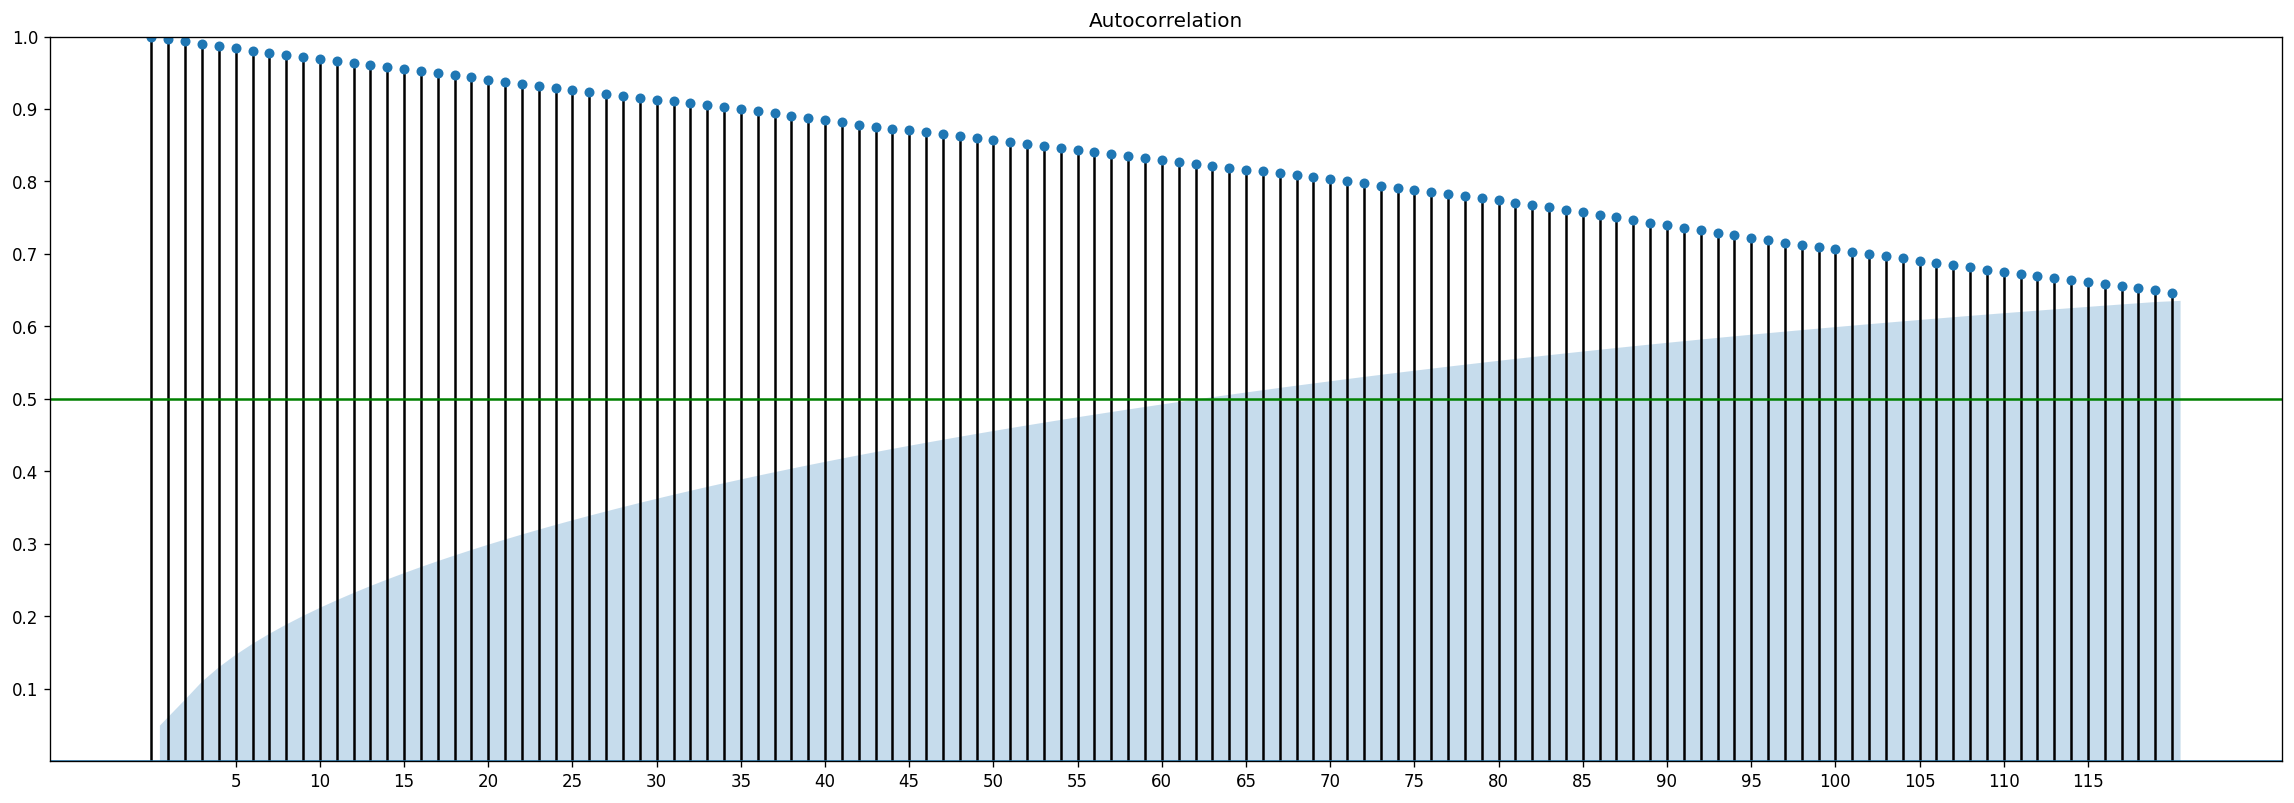

In [ ]:
fig, ax = plt.subplots(figsize=(24,8))
plot_acf(fb_df['Close'].values, lags=120, ax=ax)
plt.ylim([0,1])
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.xticks(np.arange(5, 120, 5))
plt.axhline(y=0.5, color="green")
plt.show()

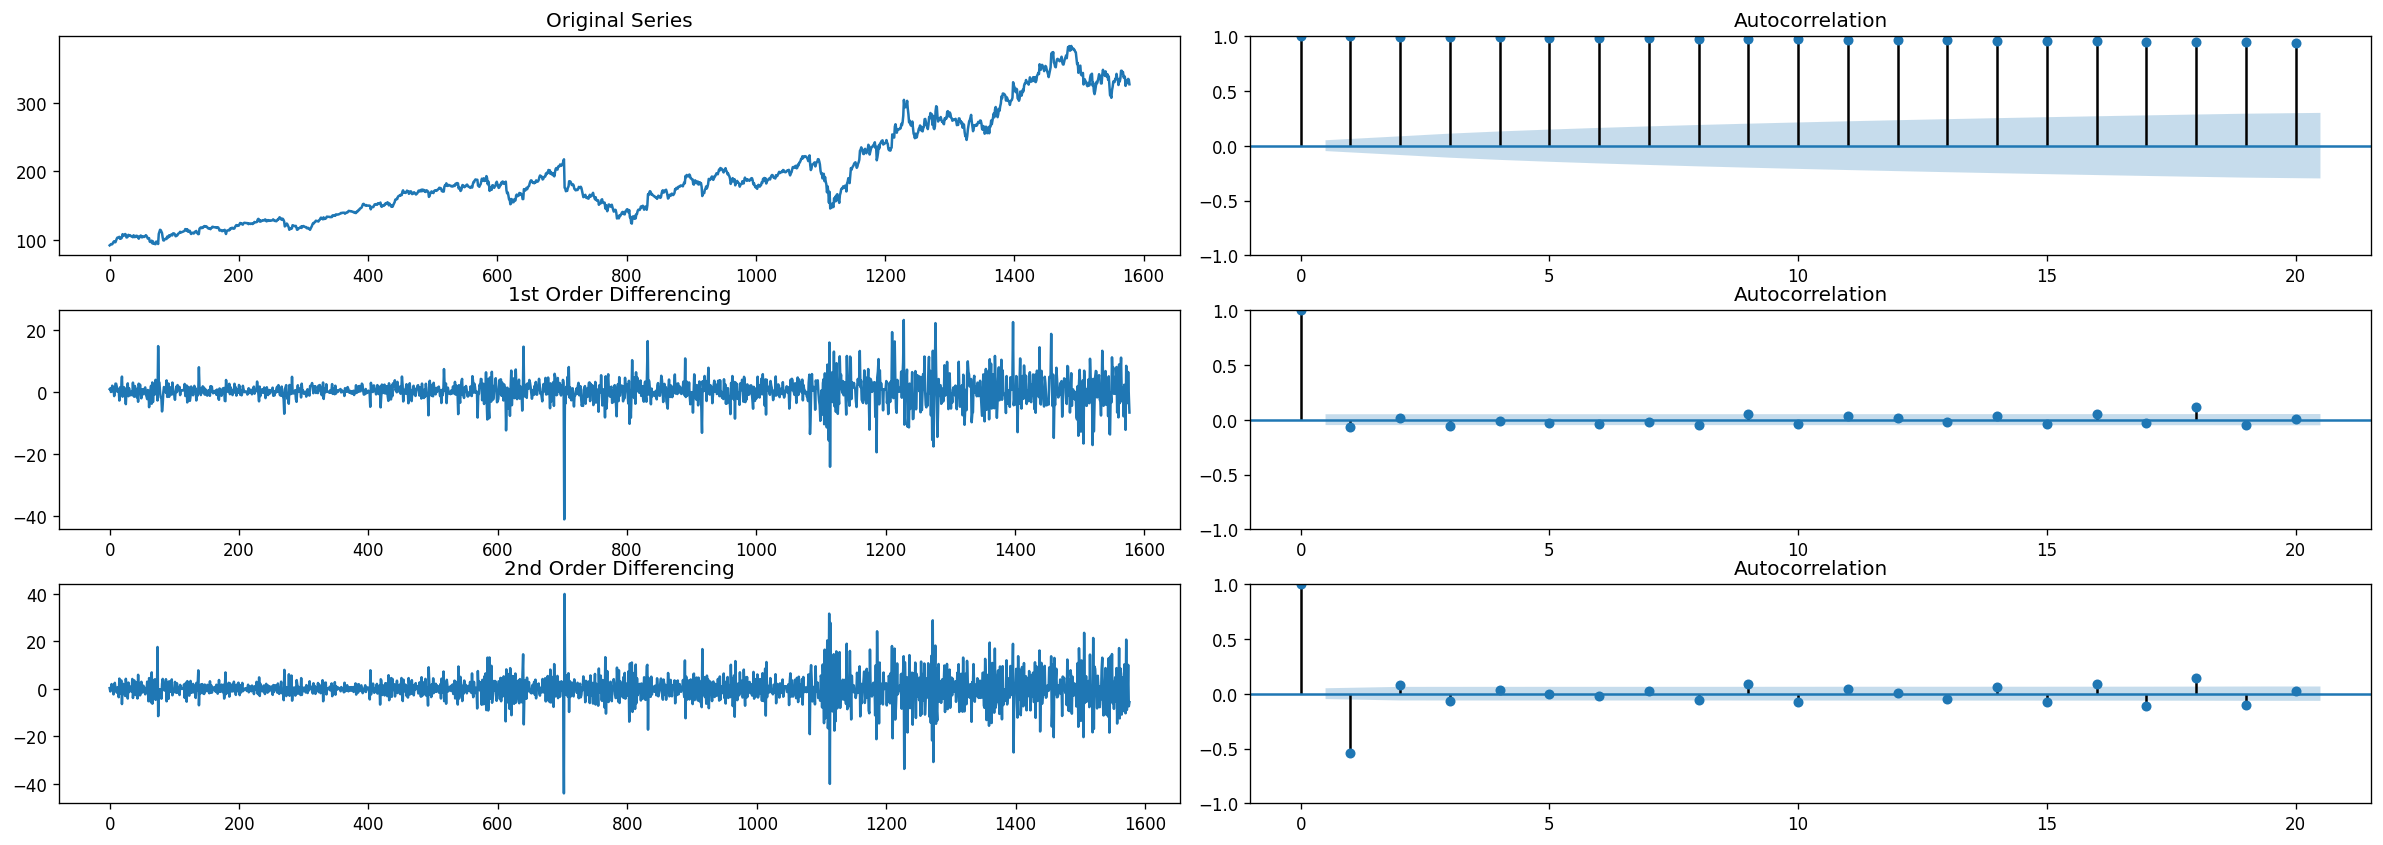

In [ ]:
#P = 1, D = 1, Q = 1

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(20,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
fig.tight_layout()
axes[0, 0].plot(fb_df['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(fb_df['Close'].values, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(np.diff(fb_df['Close'].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(fb_df['Close'].values), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(fb_df['Close'].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(fb_df['Close'].values)), ax=axes[2, 1], lags=20)

plt.show()

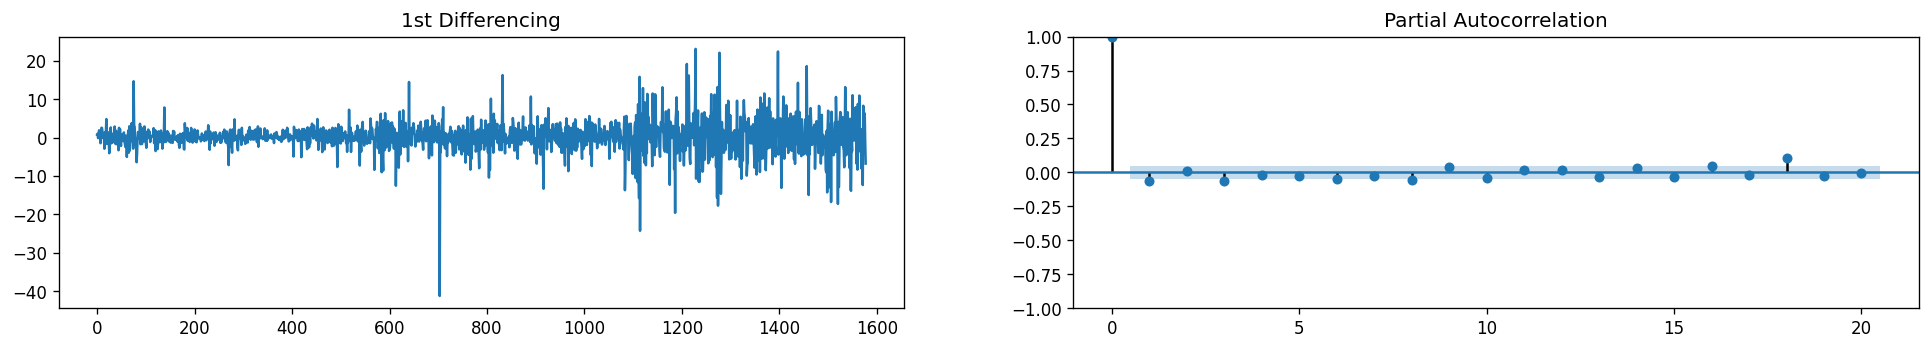

In [ ]:
plt.rcParams.update({'figure.figsize':(20,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(np.diff(fb_df['Close'].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(fb_df['Close'].values), ax=axes[1], lags=20)

plt.show()

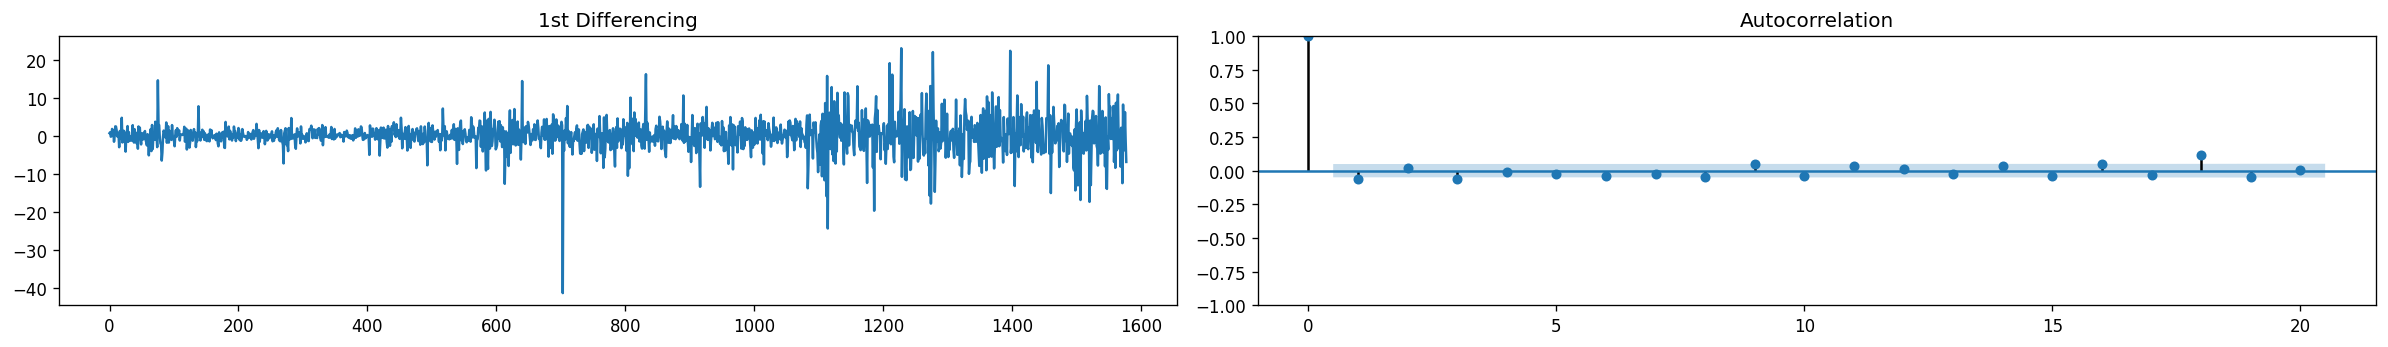

In [ ]:

plt.rcParams.update({'figure.figsize':(20,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(np.diff(fb_df['Close'].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(np.diff(fb_df['Close'].values), ax=axes[1], lags=20)
fig.tight_layout()
plt.show()


In [ ]:
stepwise_fit_arima_fb = auto_arima(fb_df['Close'], suppress_warnings=True ,trace=True )
print(stepwise_fit_arima_fb.summary)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9000.800, Time=3.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9007.859, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9003.483, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9003.617, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9007.829, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9005.717, Time=2.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9005.721, Time=2.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8999.953, Time=3.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8998.240, Time=1.29 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9001.546, Time=0.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=9000.140, Time=1.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9005.232, Time=0.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=9003.111, Time=0.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=9001.928, Time=2.67 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [ ]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return np.array(diff)

In [ ]:
X_fb = fb_df['Close'].iloc[:-15]
train_fb, test_fb = X_fb[1:len(X_fb)-(int(len(X_fb)*0.2))], X_fb[len(X_fb)-(int(len(X_fb)*0.2)):]
differenced_fb = difference(train_fb, 365)
model_fb = ARIMA(differenced_fb, order=(3,1,1))
model_fit_fb = model_fb.fit()
predictions_fb = model_fit_fb.predict(start=len(train_fb), end=len(train_fb)+len(test_fb)-1, dynamic=False, typ="levels")
residuals_fb = pd.DataFrame(model_fit_fb.resid).dropna()

In [ ]:
print("Train length: "+str(len(train_fb)))
print("Test length: "+str(len(test_fb)))

Train length: 1251
Test length: 312


In [ ]:
print(model_fit_fb.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  886
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -2693.467
Date:                Fri, 15 Apr 2022   AIC                           5396.935
Time:                        22:17:05   BIC                           5420.863
Sample:                             0   HQIC                          5406.083
                                - 886                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3608      1.295     -0.279      0.780      -2.898       2.176
ar.L2          0.0067      0.059      0.113      0.910      -0.109       0.123
ar.L3         -0.0148      0.051     -0.289      0.7

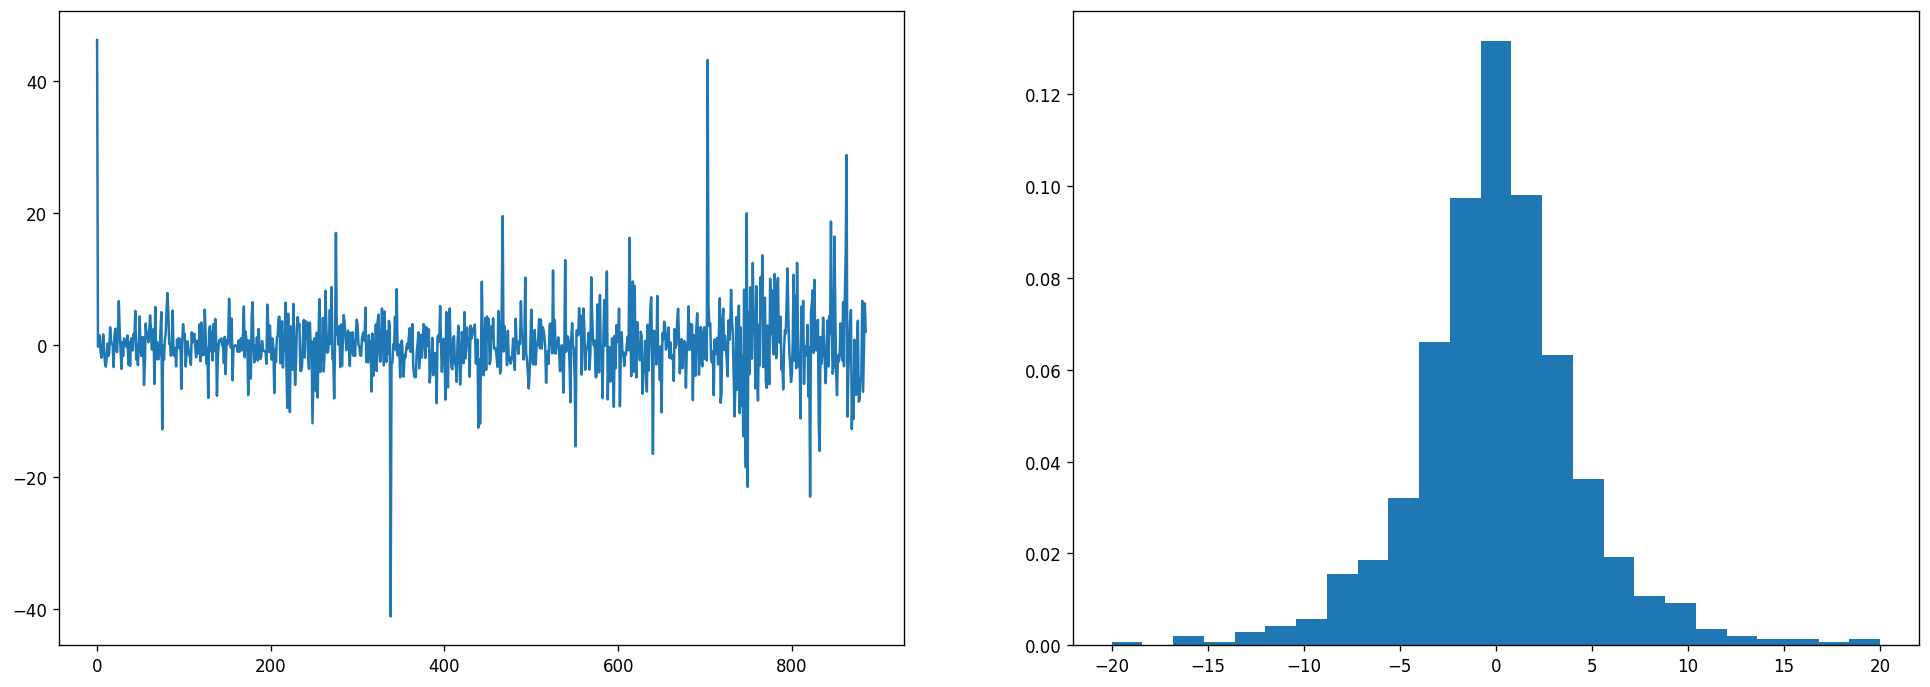

In [ ]:
plt.rcParams.update({'figure.figsize':(20,7), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(residuals_fb.values)
axes[1].hist(residuals_fb.values, density=True, bins=25, range=(-20,20))
plt.show()

In [ ]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
forecast_fb = model_fit_fb.forecast(steps=15)
history_fb = [x for x in X_fb]
forecast_list_fb = []
day = 1
for yhat in forecast_fb:
	inverted = inverse_difference(history_fb, yhat, 365)
	print('Day %d: %f' % (day, inverted))
	forecast_list_fb.append(inverted)
	history_fb.append(inverted)
	day += 1

Day 1: 318.289548
Day 2: 318.874336
Day 3: 319.966637
Day 4: 323.359434
Day 5: 319.689343
Day 6: 317.809505
Day 7: 310.539413
Day 8: 308.649453
Day 9: 311.439429
Day 10: 308.059433
Day 11: 311.229427
Day 12: 312.439435
Day 13: 331.609433
Day 14: 329.899442
Day 15: 327.769437


In [ ]:
real_values_fb = fb_df['Close'].iloc[-15:]
rmse_fb = sqrt(mean_squared_error(real_values_fb.values, forecast_list_fb))
print('Test RMSE: %.3f' % rmse_fb)

Test RMSE: 20.107


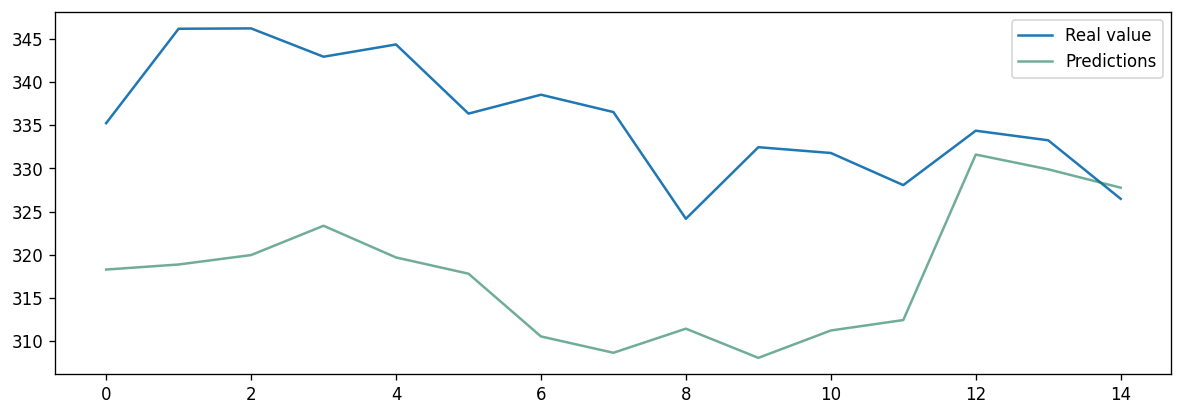

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
pyplot.plot(real_values_fb.values, label="Real value")
pyplot.plot(forecast_list_fb, color='#1759', label="Predictions")
plt.legend()
pyplot.show()

In [ ]:
ts_decompose_add_ge = seasonal_decompose(ge_df['Close'], model='additive', period=120)

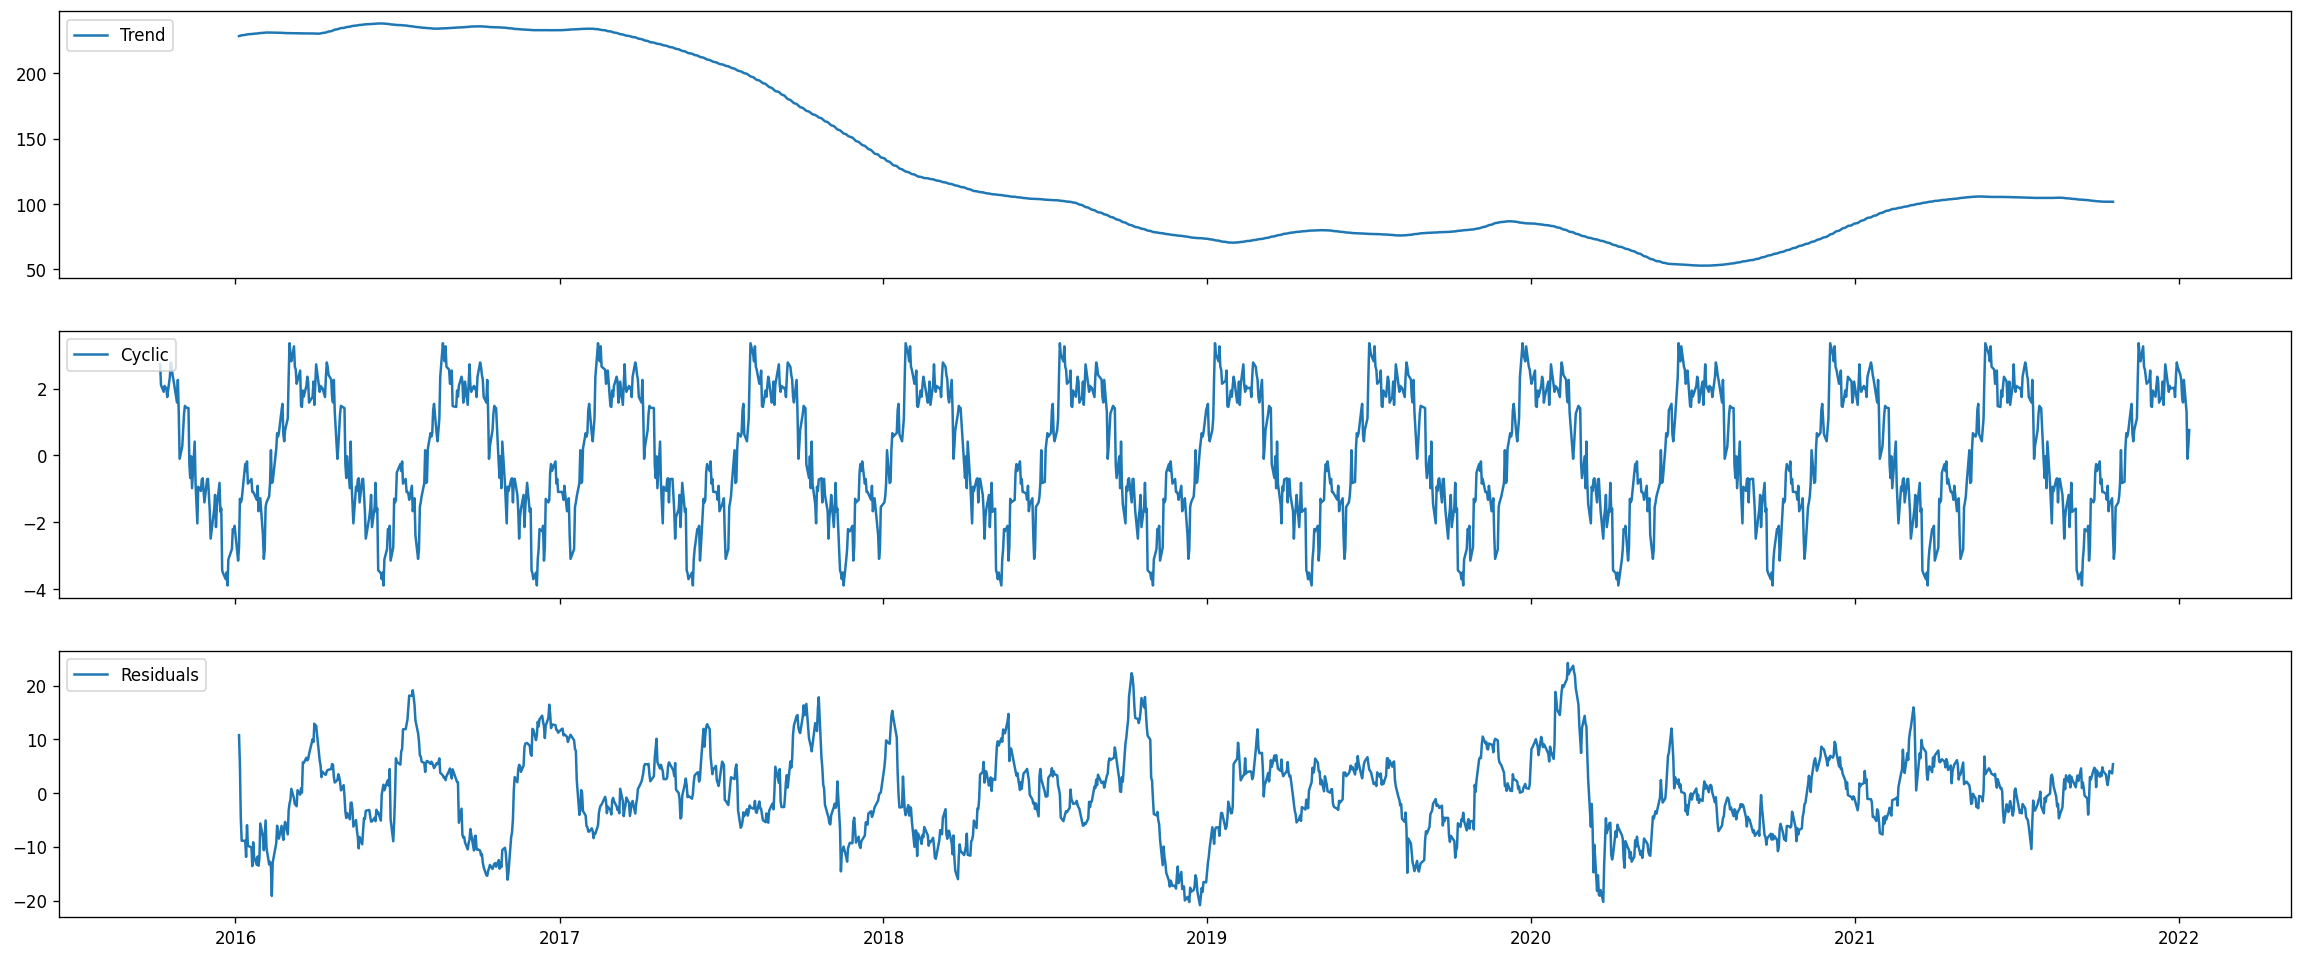

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(24)

axes[0].plot(ts_decompose_add_ge.trend, label='Trend')
axes[0].legend(loc='upper left');

axes[1].plot(ts_decompose_add_ge.seasonal, label='Cyclic')
axes[1].legend(loc='upper left');

axes[2].plot(ts_decompose_add_ge.resid, label='Residuals')
axes[2].legend(loc='upper left');

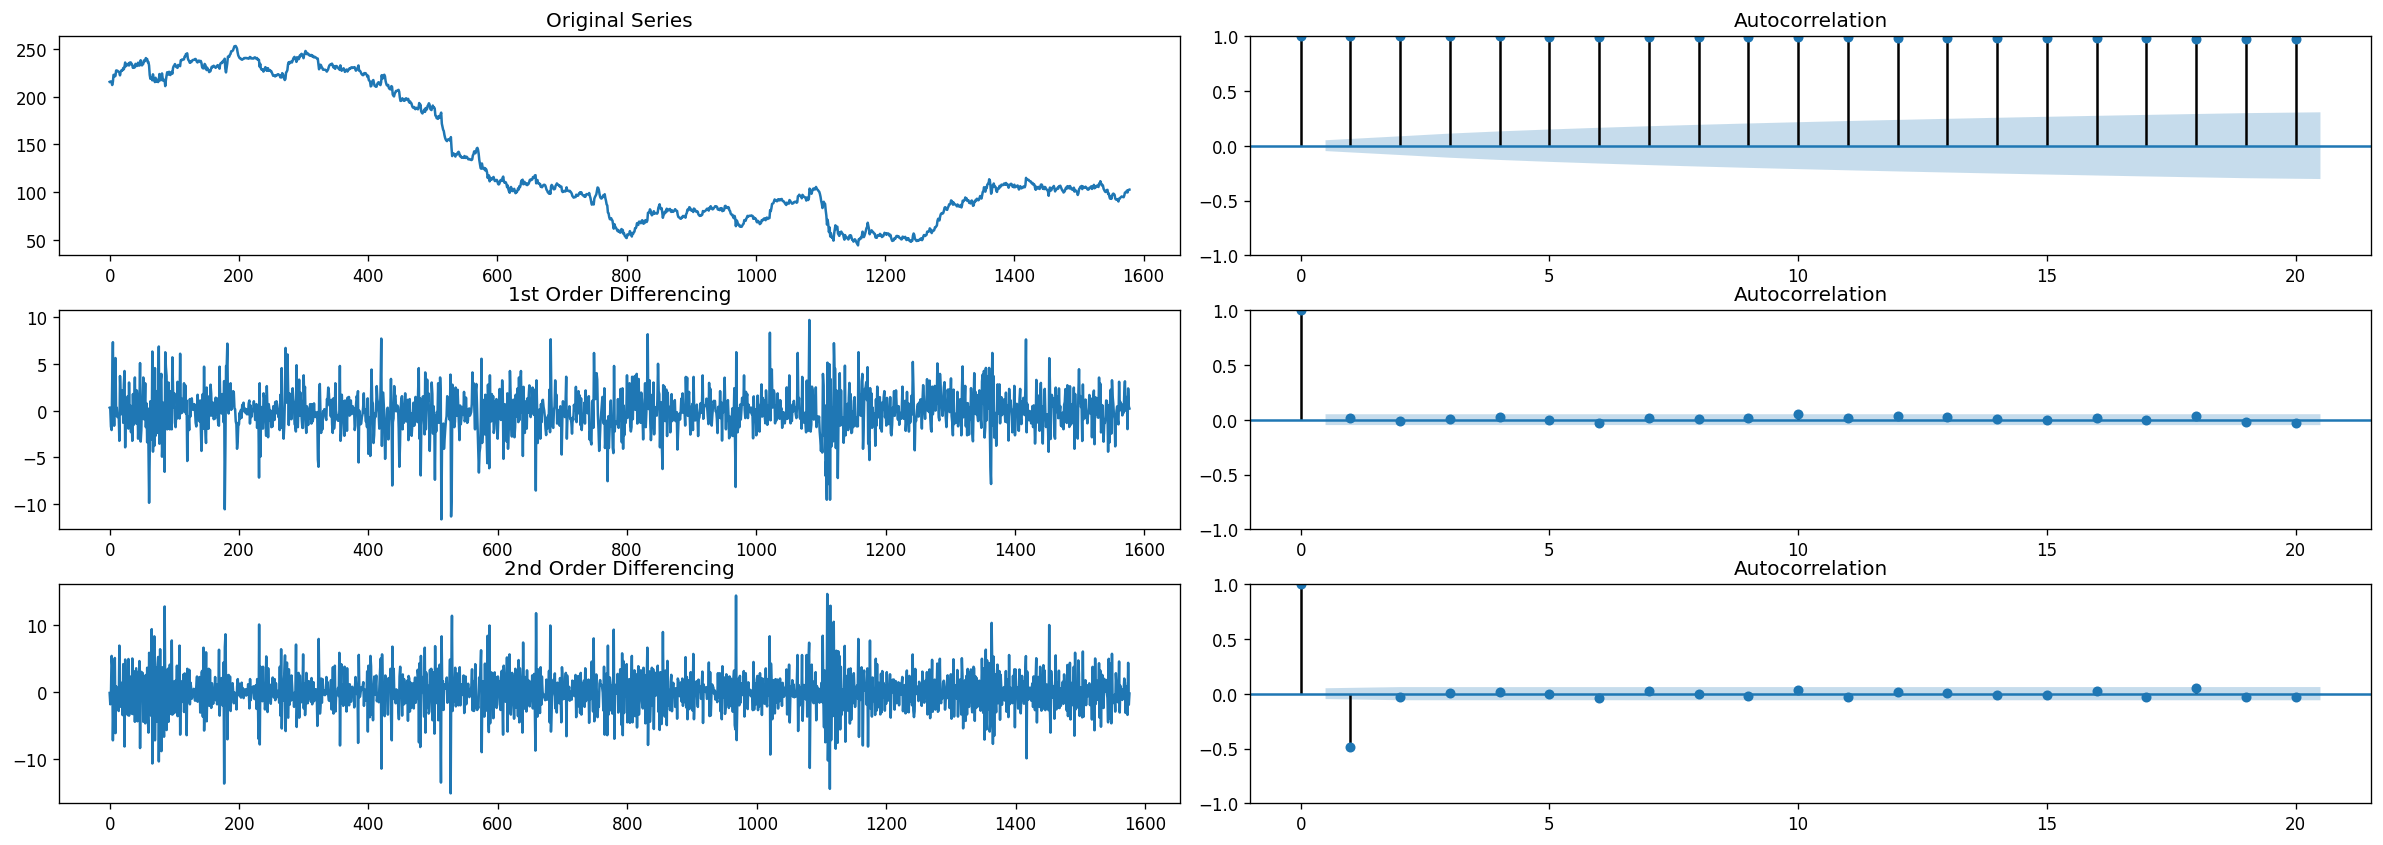

In [ ]:
plt.rcParams.update({'figure.figsize':(20,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
fig.tight_layout()
axes[0, 0].plot(ge_df['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(ge_df['Close'].values, ax=axes[0, 1], lags=20)

# 1st Differencing
axes[1, 0].plot(np.diff(ge_df['Close'].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(ge_df['Close'].values), ax=axes[1, 1], lags=20)

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(ge_df['Close'].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(ge_df['Close'].values)), ax=axes[2, 1], lags=20)

plt.show()

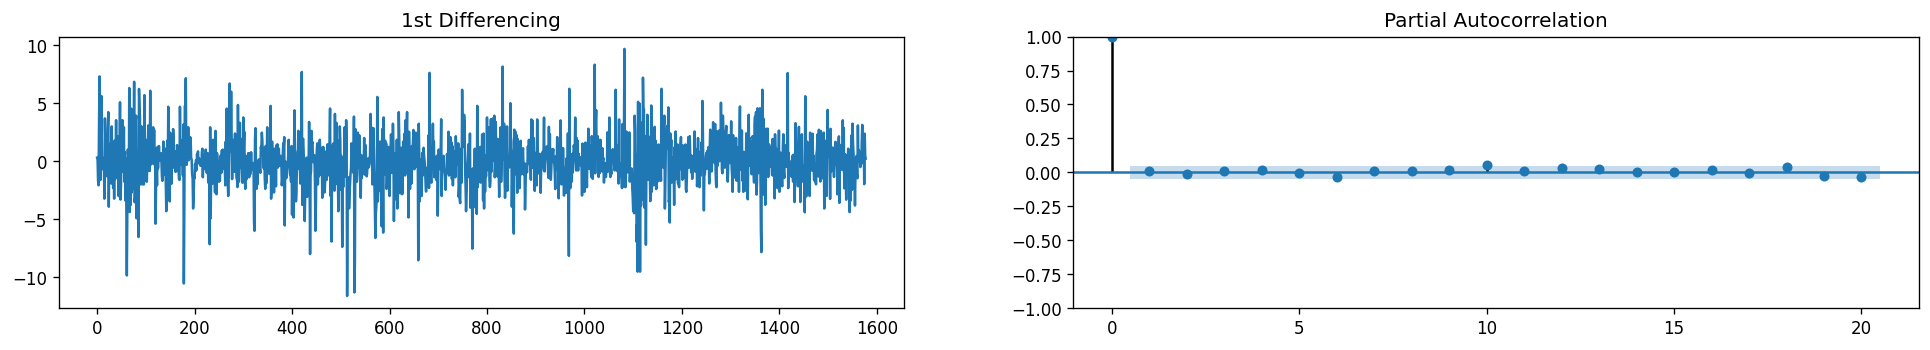

In [ ]:
plt.rcParams.update({'figure.figsize':(20,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(np.diff(ge_df['Close'].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(ge_df['Close'].values), ax=axes[1], lags=20)

plt.show()

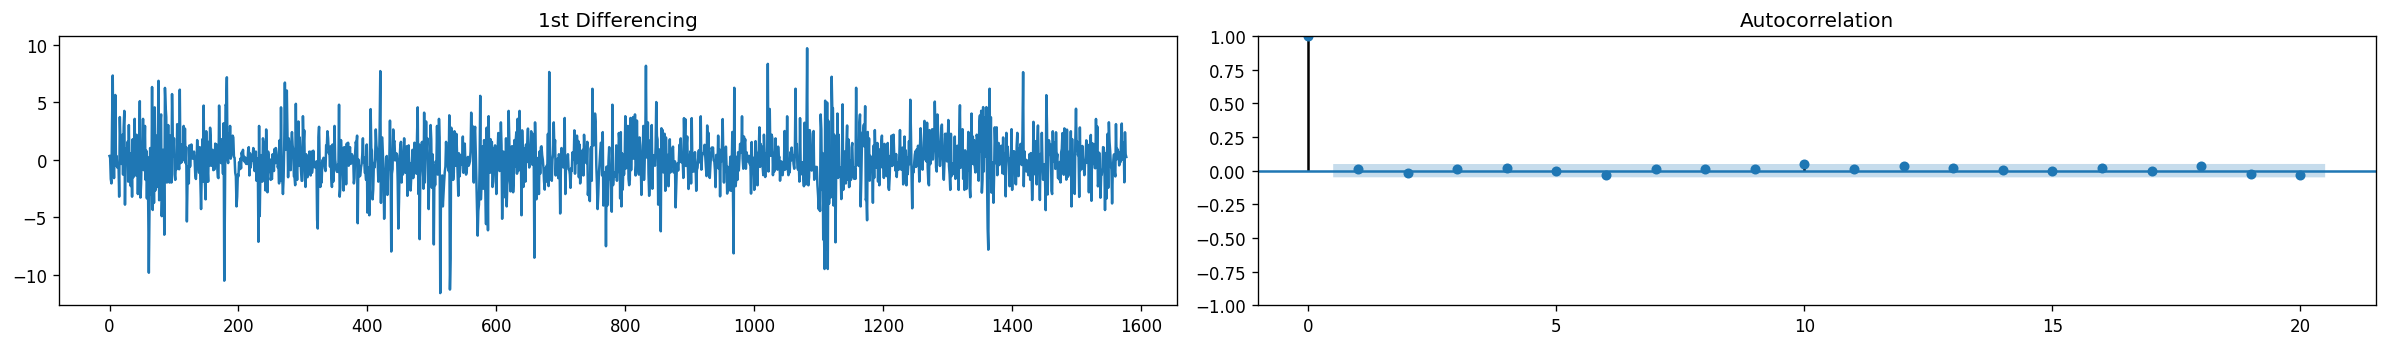

In [ ]:
plt.rcParams.update({'figure.figsize':(20,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(np.diff(ge_df['Close'].values)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(np.diff(ge_df['Close'].values), ax=axes[1], lags=20)
fig.tight_layout()
plt.show()

In [ ]:
stepwise_fit_arima_ge = auto_arima(ge_df['Close'], suppress_warnings=True ,trace=True )
print(stepwise_fit_arima_ge.summary)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7100.293, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7092.993, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7094.707, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7094.699, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7092.544, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7096.444, Time=0.85 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.539 seconds
<function ARIMA.summary at 0x7f08611bf950>


In [ ]:
X_ge = ge_df['Close'].iloc[:-15]
train_ge, test_ge = X_ge[1:len(X_ge)-(int(len(X_ge)*0.2))], X_ge[len(X_ge)-(int(len(X_ge)*0.2)):]
differenced_ge = difference(train_ge, 365)
model_ge = ARIMA(differenced_ge, order=(0,1,0))
model_fit_ge = model_ge.fit()
predictions_ge = model_fit_ge.predict(start=len(train_ge), end=len(train_ge)+len(test_ge)-1, dynamic=False, typ="levels")
residuals_ge = pd.DataFrame(model_fit_ge.resid).dropna()

In [ ]:
print(model_fit_ge.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  886
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2329.354
Date:                Fri, 15 Apr 2022   AIC                           4660.709
Time:                        22:17:13   BIC                           4665.494
Sample:                             0   HQIC                          4662.538
                                - 886                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.3158      0.405     27.962      0.000      10.523      12.109
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                88.20
Prob(Q):                              0.35   Pr

In [ ]:
forecast_ge = model_fit_ge.forecast(steps=15)
history_ge = [x for x in X_ge]
forecast_list_ge = []
day = 1
for yhat in forecast_ge:
	inverted = inverse_difference(history_ge, yhat, 365)
	print('Day %d: %f' % (day, inverted))
	forecast_list_ge.append(inverted)
	history_ge.append(inverted)
	day += 1

Day 1: 33.759998
Day 2: 33.040001
Day 3: 33.200001
Day 4: 31.599998
Day 5: 32.959999
Day 6: 33.119999
Day 7: 32.959999
Day 8: 31.520000
Day 9: 30.320000
Day 10: 31.759998
Day 11: 29.360001
Day 12: 26.720001
Day 13: 25.200001
Day 14: 25.520000
Day 15: 25.759998


In [ ]:
real_values_ge = ge_df['Close'].iloc[-15:]
rmse_ge = sqrt(mean_squared_error(real_values_ge.values, forecast_list_ge))
print('Test RMSE: %.3f' % rmse_ge)

Test RMSE: 67.814


**Forecast**


---



In [ ]:
stock_pred_df = pd.DataFrame(forecast_list_fb)
stock_pred_df.columns = ["FB"]
stock_pred_df["GE"] = forecast_list_ge

In [ ]:
spy_stocks_df = pd.DataFrame(fb_df['Close'])
spy_stocks_df.columns = ["FB"]
spy_stocks_df["GE"] = ge_df['Close']
spy_stocks_df["SPY"] = SPY['Close']

In [ ]:
X = spy_stocks_df.iloc[:,:2].values
Y = spy_stocks_df.iloc[:,2:3].values

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
# X_scale = min_max_scaler.fit_transform(X)
X_scale = X

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.2)

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)

0.9478943497739546
[[ 0.95864697 -0.06711131]]


In [ ]:
df_pred_spy = reg.predict(X_val_and_test)

In [ ]:
SPY_output_df = pd.DataFrame()
SPY_output_df['SPY_pred'] = list(df_pred_spy)
SPY_output_df['SPY'] = SPY.iloc[len(SPY)-316:,:1]['Close'].values

In [ ]:
SPY_pred_list = []
for index,row in SPY_output_df.iterrows():
  SPY_pred_list.append(list(row['SPY_pred'])[0])

In [ ]:
SPY_output_df['SPY_pred'] = SPY_pred_list